In [79]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
from refrtomo.segyshot import SegyShot
from refrtomo.VolvoHelper import *
from refrtomo.picking import *

# Volvo Dataset

In [80]:
inputfile = '../data/ST10010_1150780_40203_2dline1.sgy'
velfile = '../data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

f = segyio.open(inputfile, ignore_geometry=True)
t = f.samples

nTraces =  f.bin[segyio.BinField.Traces]

# to call one trace
tr = f.trace[0]

# Pressure shot gather (note that for each receiver the data is organized as follows: P,VZ,VX,VY.
# So we take every 4th trace)

# first shot gather
d = segyio.collect(f.trace[:240*4])
PData = d[::4]


sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
nRec = sg.nrec
nT = sg.nt
sg.interpret()
# local regular axis
sg.rotategeometry(velfile=velfile, plotflag=0)
# sg.showgeometry(local=True)

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


(49.79340614637832, 241, 49.54097588003794, 109)

In [81]:
fv = segyio.open(velfile)

# Depth axes
z = fv.samples
il, xl = fv.ilines, fv.xlines
# Velocity model
vmod = segyio.cube(velfile)
print(f"3D velocity model size {vmod.shape}")
print(f"Number of sources = {len(sg.srcx)}")

3D velocity model size (109, 241, 226)
Number of sources = 30


## One shot

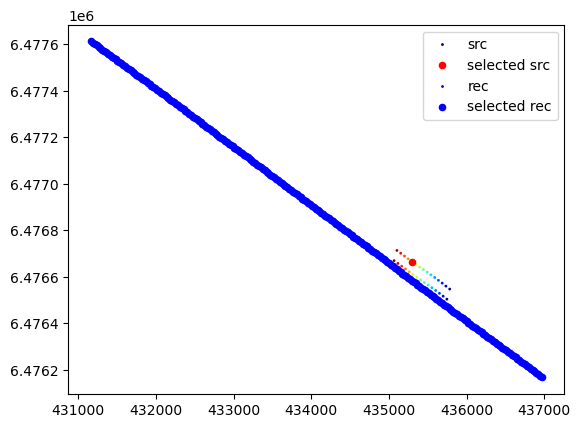

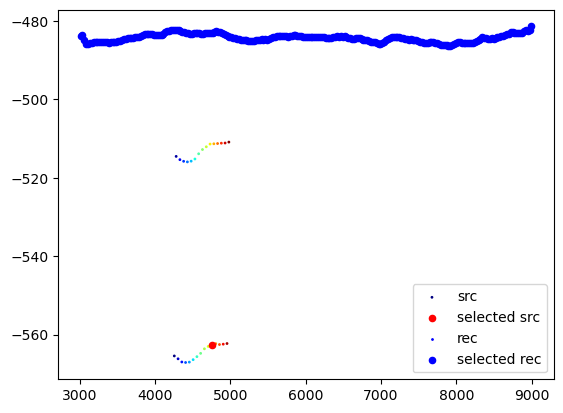

In [82]:
# Single shot
vel_dir = 1480.
ishotc = 20
sg.selectsrcs(ishotc, ishotc+1, plotflag=True)
dt = sg.dt
sg.showgeometry(local=True)

shot = sg.get_shotgather(ishotc)

Geometrical spreading and removing some aliasing 

In [83]:
# to correct for geometrical spreading
tgain = np.sqrt(sg.t)
PData = shot['P'].T * tgain[:, np.newaxis]

# to remove aliasing
pfilt = butter_lowpass_filter(shot['P'], 55., 1/sg.dt, 11)
Pfiltfk = np.fft.fft2(pfilt, s=(nRec, nT))

PData_fk = pfilt.T * tgain[:, np.newaxis]


# Compute direct arrival
drec = np.mean(np.abs(np.diff(sg.recx_local)))
offset = np.sqrt((sg.srcx[ishotc] - sg.recx) ** 2 + (sg.srcy[ishotc] - sg.recy) ** 2)
distance = np.sqrt((sg.srcz[ishotc] - sg.recz) ** 2 + \
                   (sg.srcx[ishotc] - sg.recx) ** 2 + \
                   (sg.srcy[ishotc] - sg.recy) ** 2)
tdir = distance / vel_dir
offsetreg = np.linspace(-offset[0], offset[-1], sg.nrec)

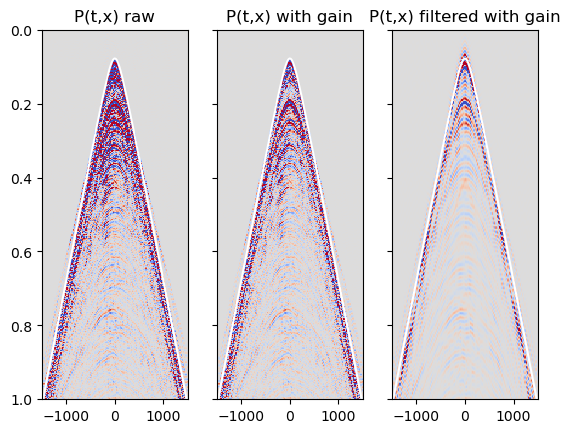

In [84]:
# Display
vmax = 3e6
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True) #, figsize=(16, 14))
axs[0].imshow(shot['P'].T, cmap='coolwarm', vmin=-vmax, vmax=vmax,
          extent=(offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]), interpolation='none')
axs[0].plot(offsetreg, tdir, '-w')
axs[0].set_title('P(t,x) raw')
axs[0].axis('tight')
axs[1].imshow(PData, cmap='coolwarm', vmin=-vmax, vmax=vmax,
          extent=(offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]), interpolation='none')
axs[1].plot(offsetreg, tdir, '-w')
axs[1].set_title('P(t,x) with gain')
axs[1].axis('tight')


axs[2].imshow(PData_fk, cmap='coolwarm', vmin=-vmax, vmax=vmax,
          extent=(offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]), interpolation='none')
axs[2].plot(offsetreg, tdir, '-w')
axs[2].set_title('P(t,x) filtered with gain')
axs[2].axis('tight')

axs[2].set_xlim(-1500, 1500)
axs[2].set_ylim(1, 0);

# First Break Picking

the **first arrival time** refers to the earliest time at which a seismic wave arrives at a sensor or receiver.

In [85]:
ind_offset = np.argmin(np.abs(offsetreg)) #index of the zero offset receiver with respect to the shot
ind_t = np.where(sg.t == 1)[0][0] # take the first second of recording only 
t_ = sg.t[:] 

x = PData_fk[:, :]

## 1st approached: treating trace by trace 

First significant amplitude at time 0.39s with value -408809.09


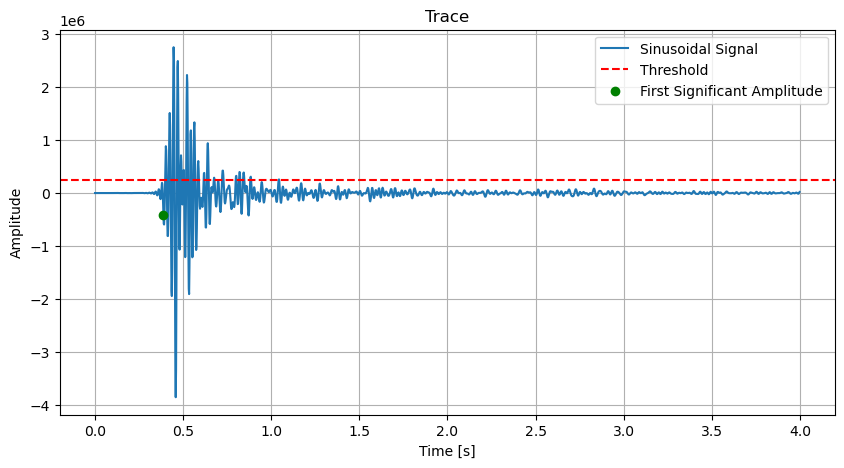

In [86]:
signal = x[:, 145]  # Sinusoidal signal

# 2. Set the threshold
threshold = 0.09 * np.max(signal)  # Threshold as 50% of max amplitude

# 3. Find the first significant amplitude
significant_indices = np.where(np.abs(signal) > threshold)[0]  # Find indices
if significant_indices.size > 0:
    first_index = significant_indices[0]  # First significant index
    first_time = t_[first_index]  # Corresponding time
    first_amplitude = signal[first_index]  # Corresponding amplitude
    print(f"First significant amplitude at time {first_time:.2f}s with value {first_amplitude:.2f}")
else:
    print("No significant amplitude found!")

# 4. Plot the signal and highlight the first significant amplitude
plt.figure(figsize=(10, 5))
plt.plot(t_, signal, label="Sinusoidal Signal")
plt.axhline(threshold, color="r", linestyle="--", label="Threshold")
if significant_indices.size > 0:
    plt.scatter(first_time, first_amplitude, color="g", label="First Significant Amplitude", zorder=5)
plt.title("Trace")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()


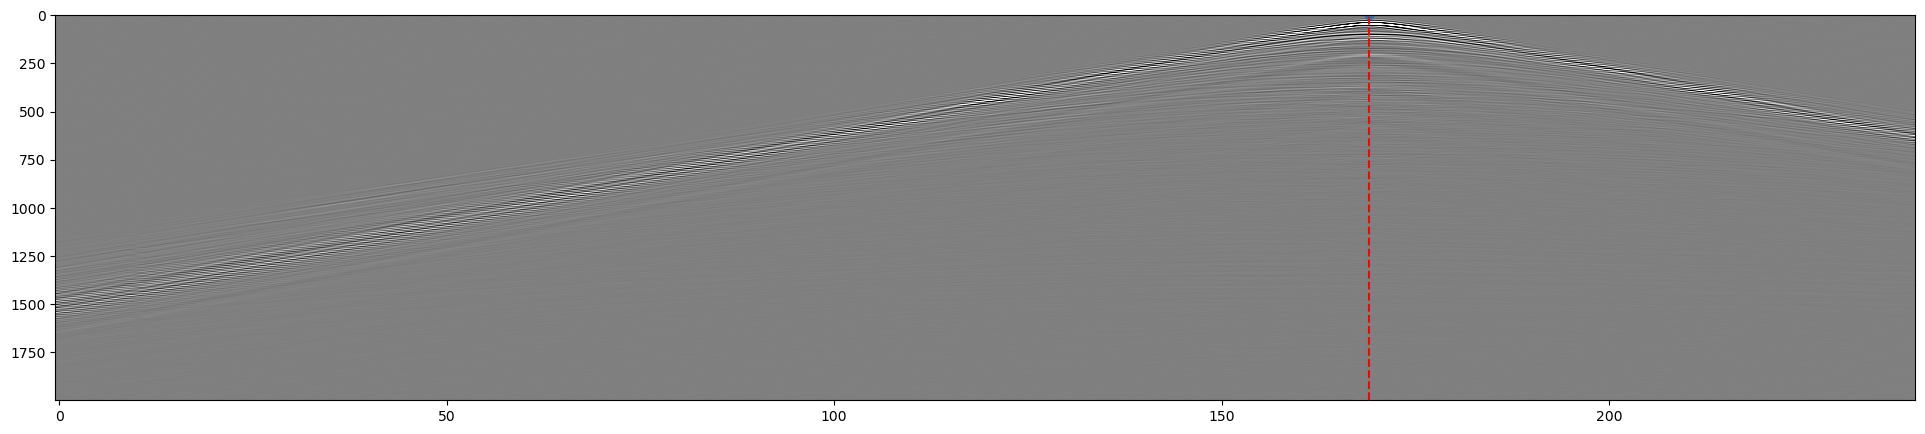

In [87]:
plt.figure(figsize=(24, 5))
plt.imshow(x, cmap='gray', vmin=-vmax, vmax=vmax, interpolation='sinc')
plt.scatter(ind_offset, 0)
plt.axvline(x=ind_offset, color='red', linestyle='--', label='Vertical Line')
plt.gca().set_aspect('auto')

In [88]:
picks_idx = []
picks_ti = []
for rec in range(x.shape[1]):
    signal = x[:, rec]
    threshold = 0.09 * np.max(signal)
    significant_indices = np.where(np.abs(signal) > threshold)[0]
    if significant_indices.size > 0:
        first_index = significant_indices[0]  # First significant index
        first_time = t_[first_index]  # Corresponding time
    picks_idx.append(first_index)
    picks_ti.append(first_time)
    
# 5. Smooth the adjusted times
picks_ti = sp.ndimage.gaussian_filter1d(picks_ti, sigma=2)  # Gaussian smoothing

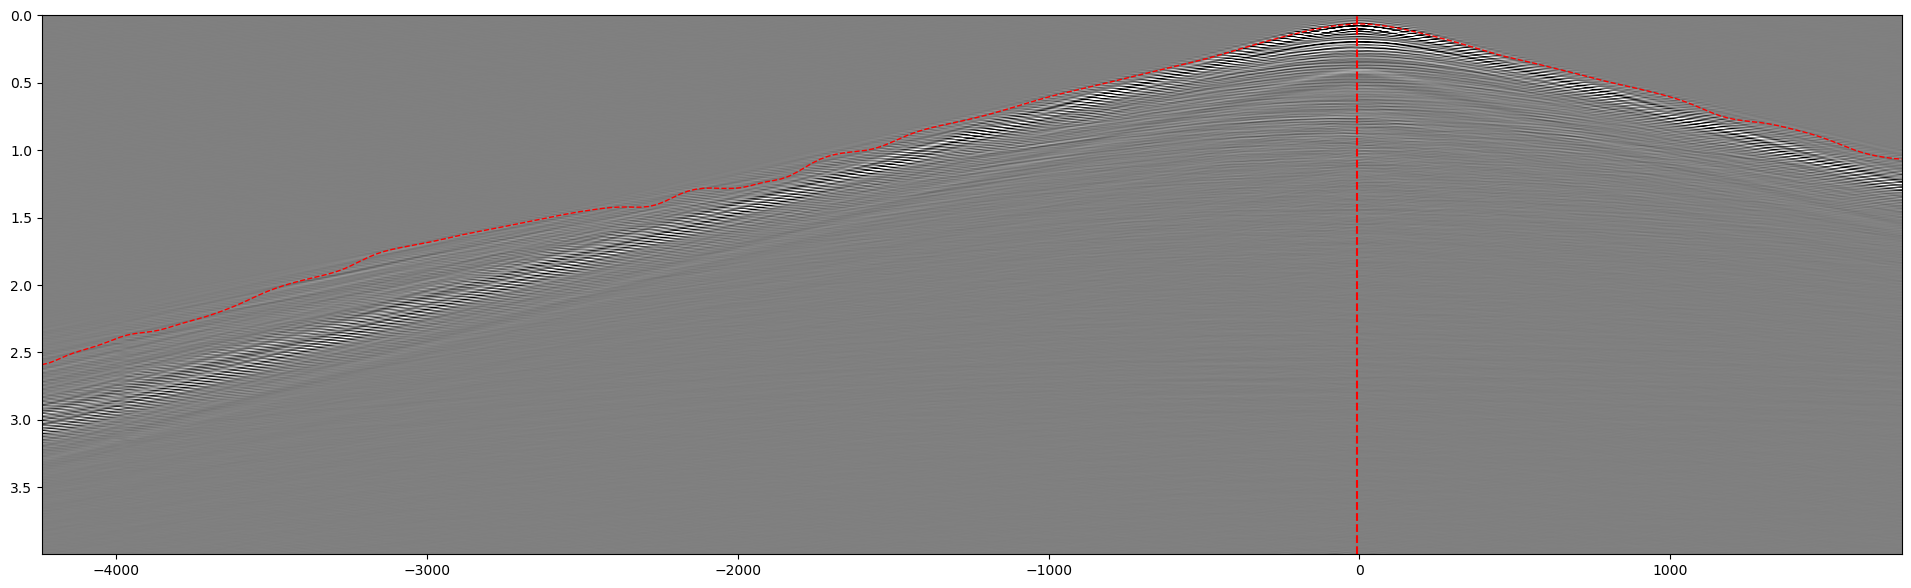

In [89]:
plt.figure(figsize=(24, 7))
plt.imshow(x, cmap='gray', vmin=-vmax, vmax=vmax, interpolation='sinc', extent=(offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
# plt.scatter(np.arange(len(offsetreg)),picks_idx)
plt.plot(offsetreg, picks_ti, '--r', lw=1, label='Time picks')
plt.axvline(x=offsetreg[ind_offset], color='red', linestyle='--', label='Vertical Line')
plt.gca().set_aspect('auto')

## 2nd appraoch: use global threshold

In [90]:
ntwin = 200 
nrec = x.shape[1]
nxmin = 40
thresh_cls = 0.0001 * np.max(x)
thresh_fr = 0.00001 * np.max(x)
recn_thrs = 10

In [91]:
# find window away from zero offset to compute average amplitude
twin = (0, ntwin)
if ind_offset < nrec // 2:
    rwin = (nrec-nxmin, nrec)
else:
    rwin = (0, nxmin)
dwin = x[twin[0]:twin[1], rwin[0]:rwin[1]]
dwinave = np.mean(np.abs(dwin))
dmask_cls = np.abs(d) > thresh_cls * dwinave
dmask_fr = np.abs(d) > thresh_fr * dwinave

In [92]:
signals = x
n_signals = signals.shape[1]
# 2. Set a global threshold
# global_threshold = 0.1 * np.max(signals)  
global_threshold_cls = thresh_cls * dwinave 
global_threshold_fr = thresh_fr * dwinave 

# 3. Find the first significant amplitude for each signal
picks_idx = []
picks_ti = []
for i in range(n_signals):
    if ind_offset-recn_thrs < i < ind_offset+recn_thrs:
        significant_indices = np.where(np.abs(signals[:, i]) > global_threshold_cls)[0]
        if significant_indices.size > 0:
            picks_idx.append(significant_indices[0])
            picks_ti.append(t_[significant_indices[0]])
        else:
            picks_idx.append(picks_idx[-1])
            picks_ti.append(picks_ti[-1])
    else:
        significant_indices = np.where(np.abs(signals[:, i]) > global_threshold_fr)[0]
        if significant_indices.size > 0:
            picks_idx.append(significant_indices[0])
            picks_ti.append(t_[significant_indices[0]])
        else:
            picks_idx.append(picks_idx[-1])
            picks_ti.append(picks_ti[-1])
        

# 5. Smooth the adjusted times
picks_ti = sp.ndimage.gaussian_filter1d(picks_ti, sigma=2)  # Gaussian smoothing

# 4. Enforce proximity condition between neighboring signals
proximity_tolerance = 0.01  # Max allowed time difference between neighbors
adjusted_times = picks_ti.copy()


for i in range(1, len(picks_ti)):
    if abs(adjusted_times[i] - adjusted_times[i - 1]) > proximity_tolerance:
        adjusted_times[i] = (adjusted_times[i - 1] + adjusted_times[i]) / 2  # Average with the neighbor


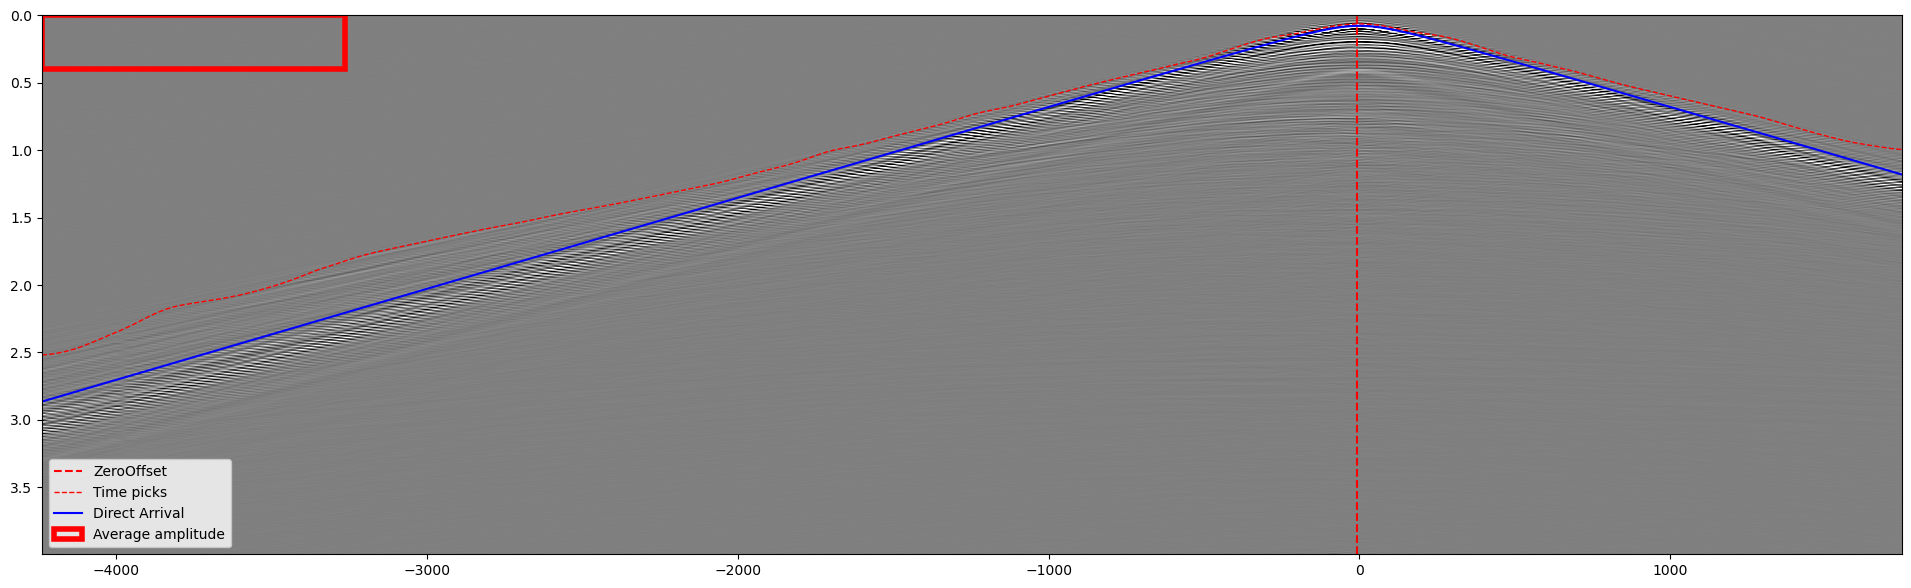

In [93]:
plt.figure(figsize=(24, 7))
plt.imshow(x[:, :], cmap='gray', vmin=-vmax, vmax=vmax, interpolation='sinc', extent=(offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
plt.axvline(x=offsetreg[ind_offset], color='red', linestyle='--', label='ZeroOffset')

# plt.plot(offsetreg, picks_ti, linestyle='-', linewidth = 2, color='green', label='Picks (Dashed)')
# plt.scatter(offsetreg, picks_ti, s=5)
plt.plot(offsetreg, picks_ti, '--r', lw=1, label='Time picks')
plt.plot(offsetreg, tdir, '-b', label='Direct Arrival')
# plt.plot(offsetreg, adjusted_times, '--b', lw=1, label='Adjusted Time picks')


ax = plt.gca()
rect = Rectangle((offsetreg[rwin[0]], t_[twin[0]]), offsetreg[rwin[1]-1]-offsetreg[rwin[0]], t_[twin[1]-1]-t_[twin[0]], 
                 edgecolor='red', facecolor='none', lw=4, label='Average amplitude')
ax.add_patch(rect)
plt.gca().set_aspect('auto')
plt.legend()
# plt.xlim(-1500, 1500)
# plt.ylim(1, 0);
plt.show()

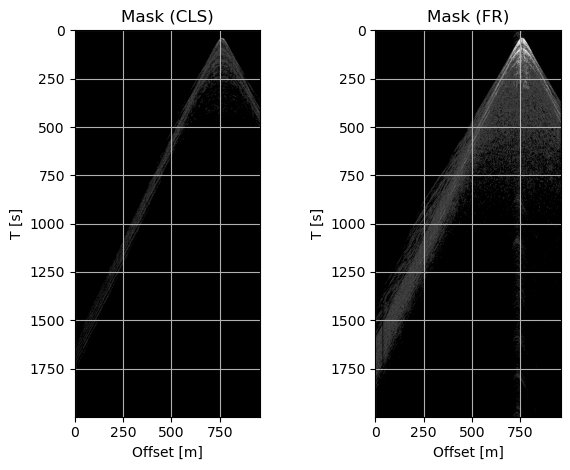

In [94]:
fig, axes = plt.subplots(1, 2)  # 1 row, 2 columns


# Plot dmask_cls.T
im1 = axes[0].imshow(dmask_cls.T, cmap='gray')
axes[0].set_title('Mask (CLS)')
axes[0].set_xlabel('Offset [m]')
axes[0].set_ylabel('T [s]')
axes[0].grid(which='both')

# Plot dmask_fr.T
im2 = axes[1].imshow(dmask_fr.T, cmap='gray')
axes[1].set_title('Mask (FR)')
axes[1].set_xlabel('Offset [m]')
axes[1].set_ylabel('T [s]')
axes[1].grid(which='both')

# Adjust layout
plt.tight_layout()
plt.show()


## Application to all shots

In [97]:
tfirsts = []
tfirsts_adjs = []
for ishot in range(sg.nsrc):
    print(f"start picking rec {ishot}")
    shot = sg.get_shotgather(ishot)
    pfilt = butter_lowpass_filter(shot['P'], 55., 1/sg.dt, 11)
    PData_fk = pfilt.T * tgain[:, np.newaxis]
    ind_offset = np.argmin(np.abs(offsetreg))
    x = PData_fk[:, :]
    
    
    thresh_cls = 0.0001 * np.max(x)
    thresh_fr = 0.00001 * np.max(x)
    twin = (0, ntwin)
    if ind_offset < nrec // 2:
        rwin = (nrec-nxmin, nrec)
    else:
        rwin = (0, nxmin)
    dwin = x[twin[0]:twin[1], rwin[0]:rwin[1]]
    dwinave = np.mean(np.abs(dwin))
    dmask_cls = np.abs(d) > thresh_cls * dwinave
    dmask_fr = np.abs(d) > thresh_fr * dwinave
    
    
    signals = x
    n_signals = signals.shape[1]
    # 2. Set a global threshold
    # global_threshold = 0.1 * np.max(signals)  
    global_threshold_cls = thresh_cls * dwinave 
    global_threshold_fr = thresh_fr * dwinave 
    
    # 3. Find the first significant amplitude for each signal
    picks_idx = []
    picks_ti = []
    for i in range(n_signals):
        if ind_offset-recn_thrs < i < ind_offset+recn_thrs:
            significant_indices = np.where(np.abs(signals[:, i]) > global_threshold_cls)[0]
            if significant_indices.size > 0:
                picks_idx.append(significant_indices[0])
                picks_ti.append(t_[significant_indices[0]])
            else:
                picks_idx.append(picks_idx[-1])
                picks_ti.append(picks_ti[-1])
        else:
            significant_indices = np.where(np.abs(signals[:, i]) > global_threshold_fr)[0]
            if significant_indices.size > 0:
                picks_idx.append(significant_indices[0])
                picks_ti.append(t_[significant_indices[0]])
            else:
                picks_idx.append(picks_idx[-1])
                picks_ti.append(picks_ti[-1])
            
    
    # 5. Smooth the adjusted times
    picks_ti = sp.ndimage.gaussian_filter1d(picks_ti, sigma=2)  # Gaussian smoothing
    
    # 4. Enforce proximity condition between neighboring signals
    proximity_tolerance = 0.01  # Max allowed time difference between neighbors
    adjusted_times = picks_ti.copy()
    
    
    for i in range(1, len(picks_ti)):
        if abs(adjusted_times[i] - adjusted_times[i - 1]) > proximity_tolerance:
            adjusted_times[i] = (adjusted_times[i - 1] + adjusted_times[i]) / 2  # Average with the neighbor

    
    tfirsts.append(picks_ti)
    tfirsts_adjs.append(adjusted_times)

start picking rec 0
start picking rec 1
start picking rec 2
start picking rec 3
start picking rec 4
start picking rec 5
start picking rec 6
start picking rec 7
start picking rec 8
start picking rec 9
start picking rec 10
start picking rec 11
start picking rec 12
start picking rec 13
start picking rec 14
start picking rec 15
start picking rec 16
start picking rec 17
start picking rec 18
start picking rec 19
start picking rec 20
start picking rec 21
start picking rec 22
start picking rec 23
start picking rec 24
start picking rec 25
start picking rec 26
start picking rec 27
start picking rec 28
start picking rec 29


In [98]:
tfirsts = np.vstack(tfirsts)
tfirsts.shape

(30, 240)

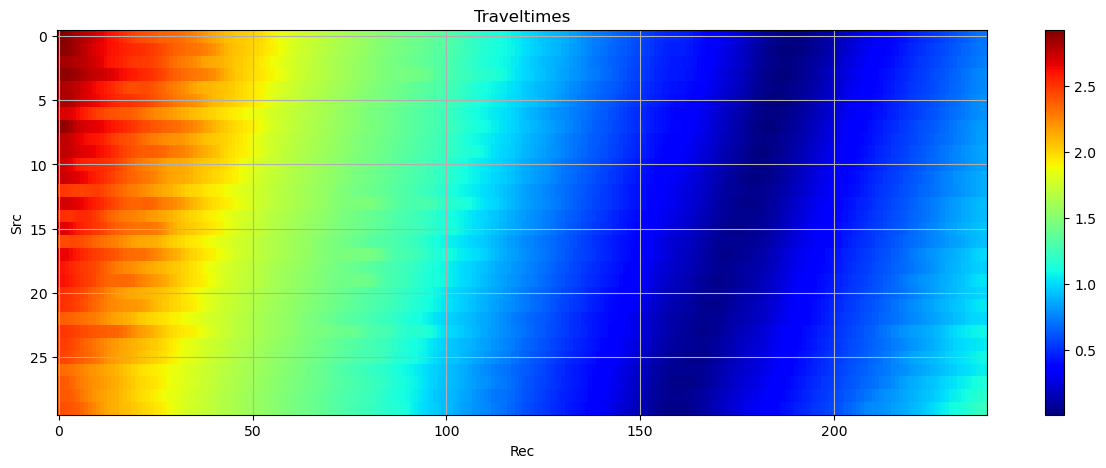

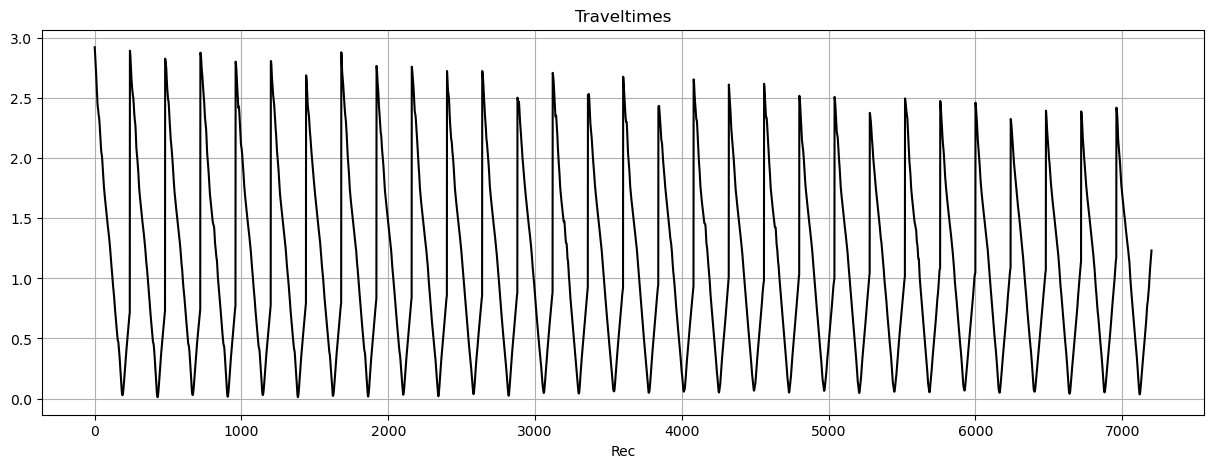

In [99]:
plt.figure(figsize=(15, 5))
plt.imshow(tfirsts, cmap='jet')
plt.axis('tight')
plt.xlabel('Rec')
plt.ylabel('Src')
plt.title('Traveltimes')
plt.grid(which='both')
plt.colorbar();

plt.figure(figsize=(15, 5))
plt.plot(tfirsts.ravel(), 'k')
plt.axis('tight')
plt.xlabel('Rec')
plt.title('Traveltimes')
plt.grid(which='both')

In [100]:
np.savez('../data/FirstArrivalVolvo', tfirst=tfirsts)